In [79]:
import os
from dotenv import load_dotenv
import pandas as pd
import sqlalchemy
from binance.client import Client

In [80]:
load_dotenv()
BINANCE_API_KEY = os.environ['BINANCE_API_KEY_DEV']
BINANCE_SECRET_KEY = os.environ['BINANCE_SECRET_KEY_DEV']

In [81]:
client = Client(BINANCE_API_KEY,BINANCE_SECRET_KEY,tld='us', testnet=True)

In [82]:
engine = sqlalchemy.create_engine('sqlite:///BTCUSDTstream.db', echo=False)

In [83]:
df = pd.read_sql('BTCUSDT', engine)

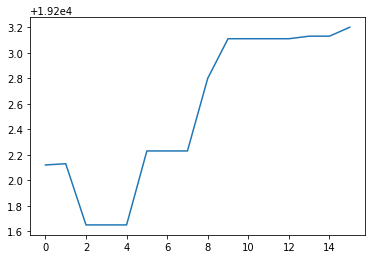

In [88]:
df.Price.plot()

In [96]:
# TrendFollowing
# if the crypto was rising by x % -> buy
# exit when profit is above 0.15% or loss is crossing -0.1%
print(pd.read_sql('BTCUSDT', engine))

      symbol                    Time     Price
0    BTCUSDT 2022-09-08 01:54:02.530  19202.12
1    BTCUSDT 2022-09-08 01:54:03.533  19202.13
2    BTCUSDT 2022-09-08 01:54:05.530  19201.65
3    BTCUSDT 2022-09-08 01:54:05.530  19201.65
4    BTCUSDT 2022-09-08 01:54:05.543  19201.65
..       ...                     ...       ...
177  BTCUSDT 2022-09-08 01:55:25.640  19192.28
178  BTCUSDT 2022-09-08 01:55:25.640  19192.28
179  BTCUSDT 2022-09-08 01:55:25.640  19192.16
180  BTCUSDT 2022-09-08 01:55:26.027  19193.24
181  BTCUSDT 2022-09-08 01:55:26.027  19193.24

[182 rows x 3 columns]


In [94]:
def strategy(entry, lookback, qty, open_position=False):
    while True:
        # Full dataframe
        df = pd.read_sql('BTCUSDT', engine)
        # Look back a the last x number of data entries
        lookbackperiod = df.iloc[-lookback:]
        # Get the percentage change (from each prev entry) of all lookback entries
        # Multiply them all cumulativley from start to end
        # Total percentage change from the given lookback period (not in units of time)
        cumret = (lookbackperiod.Price.pct_change() +1).cumprod() - 1
        if not open_position:
            # Go in if value starts to move up
            if cumret[cumret.last_valid_index()] > entry:
                # Buy some with USDT
                order = client.create_order(symbol='BTCUSDT', side='BUY', type='MARKET', quantity=qty)
                print(order)
                open_position = True
                break
    if open_position:
        while True:
            df = pd.read_sql('BTCUSDT', engine)
            # Only look at data in db where entries are after the purchase we made
            sincebuy = df.loc[df.Time > pd.to_datetime(order['transactTime'], unit='ms')]

            # Wait till we have entries
            if len(sincebuy) > 1:
                # Get latest percent change since the last purchase
                sincebuyret = (sincebuy.Price.pct_change() + 1).cumprod() - 1
                last_entry = sincebuyret[sincebuyret.last_valid_index()]

                # If latest entry is greater than x percent or negative sell
                if last_entry > 0.0015 or last_entry < -0.0015:
                    order = client.create_order(symbol='BTCUSDT', side='SELL', type='MARKET', quantity=qty)
                    print(order)
                    break

# strategy()

      symbol                    Time     Price
0    BTCUSDT 2022-09-08 01:04:31.534  19309.99
1    BTCUSDT 2022-09-08 01:04:31.534  19309.61
2    BTCUSDT 2022-09-08 01:04:31.534  19309.51
3    BTCUSDT 2022-09-08 01:04:31.550  19309.51
4    BTCUSDT 2022-09-08 01:04:31.550  19309.25
..       ...                     ...       ...
181  BTCUSDT 2022-09-08 01:05:54.169  19311.21
182  BTCUSDT 2022-09-08 01:05:54.169  19311.21
183  BTCUSDT 2022-09-08 01:05:54.387  19311.21
184  BTCUSDT 2022-09-08 01:05:54.387  19311.34
185  BTCUSDT 2022-09-08 01:05:54.400  19311.34

[186 rows x 3 columns]


In [ ]:
strategy(0.001, 60, 0.001)

In [67]:
# Buy
order = client.create_order(symbol='BTCUSDT', side='BUY', type='MARKET', quantity=0.001)
print(order)

{'symbol': 'BTCUSDT', 'orderId': 290246, 'orderListId': -1, 'clientOrderId': 'QDJgqGkR7hWpo1pm4bmWhl', 'transactTime': 1662600880993, 'price': '0.00000000', 'origQty': '0.00100000', 'executedQty': '0.00100000', 'cummulativeQuoteQty': '19.27288000', 'status': 'FILLED', 'timeInForce': 'GTC', 'type': 'MARKET', 'side': 'BUY', 'fills': [{'price': '19272.88000000', 'qty': '0.00100000', 'commission': '0.00000000', 'commissionAsset': 'BTC', 'tradeId': 110083}]}
